## Structure and populate the subfolders

In [1]:
import os
import glob

from torch import normal

data_dir = "./"

#create training dir
training_dir = os.path.join(data_dir,"training")
if not os.path.isdir(training_dir):
  os.mkdir(training_dir)

#create dog in training
jaundice_training_dir = os.path.join(training_dir,"jaundice")
if not os.path.isdir(jaundice_training_dir):
  os.mkdir(jaundice_training_dir)

#create cat in training
normal_training_dir = os.path.join(training_dir,"normal")
if not os.path.isdir(normal_training_dir):
  os.mkdir(normal_training_dir)

#create validation dir
validation_dir = os.path.join(data_dir,"validation")
if not os.path.isdir(validation_dir):
  os.mkdir(validation_dir)

#create dog in validation
jaundice_validation_dir = os.path.join(validation_dir,"jaundice")
if not os.path.isdir(jaundice_validation_dir):
  os.mkdir(jaundice_validation_dir)

#create cat in validation
normal_validation_dir = os.path.join(validation_dir,"normal")
if not os.path.isdir(normal_validation_dir):
  os.mkdir(normal_validation_dir)

### Shuffle newly aquired data in folder

In [2]:
import shutil
from numpy import size

split_size = 0.80
jaundice_imgs_size = len(glob.glob("./jaundice/jaundice/*"))
normal_imgs_size = len(glob.glob("./normal/normal/*"))


for i,img in enumerate(glob.glob("./jaundice/jaundice/*")):
  if i < (jaundice_imgs_size * split_size):
    shutil.move(img,jaundice_training_dir)

  else:
    shutil.move(img,jaundice_validation_dir)


for i,img in enumerate(glob.glob("./normal/normal/*")):
  if i < (normal_imgs_size * split_size):
    shutil.move(img,normal_training_dir)
  else:
    shutil.move(img,normal_validation_dir)

## plot some examples


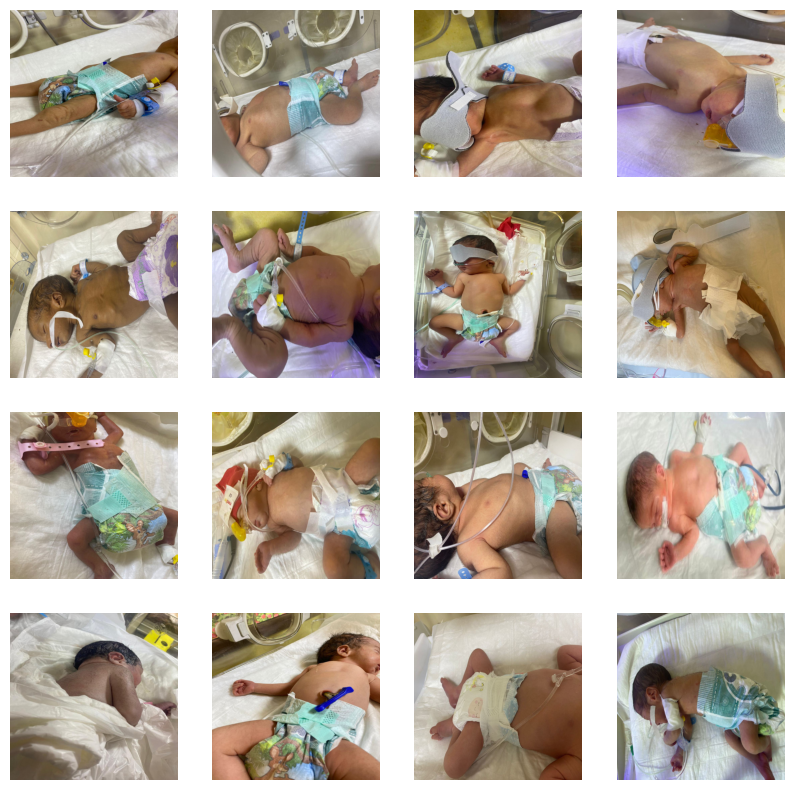

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.core.pylabtools import figsize

samples_jaundice = [os.path.join(jaundice_training_dir,np.random.choice(a = os.listdir(jaundice_training_dir),size = 1)[0]) for _ in range(8)]
samples_normal = [os.path.join(normal_training_dir,np.random.choice(a = os.listdir(normal_training_dir),size = 1)[0]) for _ in range(8)]

nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
ax = ax.flatten()

for i in range(nrows*ncols):
  if i < 8:
    pic = plt.imread(samples_jaundice[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
  else:
    pic = plt.imread(samples_normal[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
plt.show()

## Skin Detection code

In [4]:
# our custom transformer to detect only skin

import cv2
import numpy as np

def custom_skin_detector(img):
    img = np.array(img)
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    #skin color range for h in hsv
    HSV_mask = cv2.inRange(img_HSV[:,:,0], np.array((0)), np.array((17)))
    HSV_mask = cv2.morphologyEx(HSV_mask,cv2.MORPH_OPEN,np.ones((3,3),np.uint8))

    #converting from gbr to YCbCr color space
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

    #putting all values of y to 0
    img_YCrCb[:,:,0] = 0

    #skin color range for ycrcb color space 
    YCrCb_mask = cv2.inRange(img_YCrCb, np.array((0, 135, 85)), np.array((255,180,135))) 
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #global mask made from YCrCb mask and hsv mask
    global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
    global_mask=cv2.medianBlur(global_mask,3)
    global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))
    global_img = cv2.bitwise_and(img,img,mask=global_mask)
    global_img = cv2.cvtColor(global_img,cv2.COLOR_BGR2RGB)
    return global_img

## Create dataloader

Now we are going to do 3 things:

1. Let’s preprocess our data using the compose method, which is a simple method to apply multiple preprocessing functions like normalization and data augmentation to our dataset.
2. Let’s use ImageFolder to create a pytorch dataset. PyTorch infers the class automatically if the subdirectories structure is well defined (as in our case).
3. Use the DataLoader to slice our data in batches.

In [ ]:
from torchvision.datasets import ImageFolder
class PreProcessedDataset(ImageFolder):
  def __init__(self, root, loader=default_loader, is_valid_file=None):
    super(MySpecialDataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)

  def __getitem__(self, index):
    image_path, target = self.samples[index]
    # do your magic here
    im = cv2.imread(image_path)
    im_nonoise = cv2.medianBlur(im, 3)
    imgray = cv2.cvtColor(im_nonoise,cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(imgray)
    ret,thresh = cv2.threshold(cl1,110,255,0)
    image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    img = cv2.drawContours(image, contours, -1, (250,100,120))
    # you need to convert img from np.array to torch.tensor
    # this has to be done CAREFULLY!
    sample = torchvision.transforms.ToTensor()(img)
    return sample, target

In [5]:
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
from torchvision.transforms import Compose

# Define your data loaders
batch_size = 32

train_data = ImageFolder('./training', transform=Compose([ # reduce the size here to 512,512 for faster processing !!! DON'T FORGET TO MENTION IT IN PAPER !!!
                                       ToTensor(),
                                       ]))
test_data = ImageFolder('./validation', transform=Compose([ # reduce the size here to 512,512 for faster processing !!! DON'T FORGET TO MENTION IT IN PAPER !!!
                                       ToTensor(),
                                       ]))

trainloader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
)

testloader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=True,
)

# Use your skin detection code with PyTorch's DataLoader
for i, (images, labels) in enumerate(trainloader):
    # Apply skin detection to each image in the batch
    for j in range(images.shape[0]):
        img = images[j].permute(1, 2, 0).numpy()
        img = custom_skin_detector(img)
        img = torch.from_numpy(img).permute(2, 0, 1)
        images[j] = img

for i, (images, labels) in enumerate(testloader):
    # Apply skin detection to each image in the batch
    for j in range(images.shape[0]):
        img = images[j].permute(1, 2, 0).numpy()
        img = custom_skin_detector(img)
        img = torch.from_numpy(img).permute(2, 0, 1)
        images[j] = img


## training function

In [6]:
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x) #forward pass
    #enter train mode
    model.train() # make model to train
    #compute loss
    loss = loss_fn(yhat,y) # calculate loss

    loss.backward() # backward propogation
    optimizer.step() #optimizer step
    optimizer.zero_grad() 
    #optimizer.cleargrads()

    return loss
  return train_step

## Our model used

### CNN

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = "cuda" if torch.cuda.is_available() else 'cpu'
model = SimpleCNN()
model = model.to(device)

### VGG

In [8]:
# from torchvision import models
# import torch.nn as nn
# import torch

# device = "cuda" if torch.cuda.is_available() else 'cpu'
# model = models.vgg16(pretrained = True)

# model.eval()
# with torch.no_grad():
#     nn_filters = model.classifier[6].in_features
#     model.classifier[6] = nn.Linear(nn_filters,1)
#     model = model.to(device)

### resnet50/34/18

In [9]:
# from torchvision import datasets, models, transforms
# import torch.nn as nn
# import torch

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = models.resnet34(pretrained = True)


# model.eval()

# #add a new final layer
# with torch.no_grad():
#   nr_filters = model.fc.in_features  #number of input features of last layer
#   model.fc = nn.Linear(nr_filters, 1)

#   model = model.to(device)

### alexnet

In [10]:
# from torchvision import datasets, models, transforms
# import torch.nn as nn
# import torch

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = models.alexnet(pretrained=True)

# model.eval()

# # Add a new final layer
# with torch.no_grad():
#     nr_filters = model.classifier[6].in_features  # Number of input features of last layer
#     model.classifier[6] = nn.Linear(nr_filters, 1)

#     model = model.to(device)

### densnet

In [11]:
# from torchvision import datasets, models, transforms
# import torch.nn as nn
# import torch

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = models.densenet121(pretrained=True)

# model.eval()

# # Add a new final layer
# with torch.no_grad():
#     nr_filters = model.classifier.in_features  # Number of input features of last layer
#     model.classifier = nn.Linear(nr_filters, 1)

#     model = model.to(device)


### Googlenet

In [12]:
# from torchvision import models
# import torch.nn as nn
# import torch

# device = "cuda" if torch.cuda.is_available() else 'cpu'
# model = models.googlenet(pretrained = True)

# model.eval()
# with torch.no_grad():
#     nn_filters = model.fc.in_features
#     model.fc = nn.Linear(nn_filters,1)
#     model = model.to(device)

### Mobile Net

In [13]:
# from torchvision import models
# import torch.nn as nn
# import torch

# device = "cuda" if torch.cuda.is_available() else 'cpu'
# model = models.mobilenet_v2(pretrained=True)

# model.eval()
# with torch.no_grad():
#     nn_filters = model.classifier[1].in_features
#     model.classifier[1] = nn.Linear(nn_filters, 1)
#     model = model.to(device)

### Inception v3

In [14]:
# from torchvision import models
# import torch.nn as nn
# import torch

# device = "cuda" if torch.cuda.is_available() else 'cpu'
# model = models.inception_v3(pretrained=True)

# model.eval()
# with torch.no_grad():
#     nn_filters = model.fc.in_features
#     model.fc = nn.Linear(nn_filters, 1)
#     model = model.to(device)

### Squeezenet

In [15]:
from torchvision import models
import torch.nn as nn
import torch

device = "cuda" if torch.cuda.is_available() else 'cpu'
model = models.squeezenet1_1(pretrained=True)

model.eval()
with torch.no_grad():
    model.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1))
    model.num_classes = 1
    model = model.to(device)

C:\Users\divij\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\divij\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Optimizer and make train step

In [16]:
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import Adam

#loss
loss_fn = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model

#optimizer
# optimizer = Adam(model.parameters(),lr=0.01)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

#train step
train_step = make_train_step(model, optimizer, loss_fn)

## Train the model


In [17]:
def accuracy_fn(y_true, y_pred):
  ans = 1 if torch.sigmoid(y_pred) >= 0.5 else 0
  correct = torch.sum((y_true == ans))
  acc = (correct/len(y_pred))*100
  return acc

In [18]:
# %%capture
# %pip install tqdm
from tqdm import tqdm

losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []


n_epochs = 2


early_stopping_tolerance = 0.03
early_stopping_threshold = 0.003

for epoch in range(n_epochs):
  print(f"epoch {epoch} is running")
  epoch_loss = 0
  for i ,data in tqdm(enumerate(trainloader), total = len(trainloader)): #iterate ovre batches
    x_batch , y_batch = data
    x_batch = x_batch.to(device) #move to gpu
    y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
    y_batch = y_batch.to(device)

    loss = train_step(x_batch, y_batch)
    epoch_loss += loss/len(trainloader)
    losses.append(loss)

  epoch_train_losses.append(epoch_loss)
  print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

  #validation doesnt requires gradient
  with torch.no_grad():
    cum_loss = 0
    for data in testloader:
      x_batch,y_batch = data
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to(device)
      model.eval()
      yhat = model(x_batch)
      val_loss = loss_fn(yhat,y_batch)
      cum_loss += loss/len(testloader)
      val_losses.append(val_loss.item())


    epoch_test_losses.append(cum_loss)
    print(f'Epoch : {epoch+1}, val loss : {cum_loss}')

    best_loss = min(epoch_test_losses)

    #save best model
    if cum_loss <= best_loss:
      best_model_wts = model.state_dict()

    #early stopping
    early_stopping_counter = 0
    if cum_loss > best_loss:
      early_stopping_counter +=1

    if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
      print("/n Terminating: early stopping")
      break #terminate training

#load best model
model.load_state_dict(best_model_wts)

epoch 0 is running


100%|██████████| 19/19 [02:28<00:00,  7.82s/it]



Epoch : 1, train loss : 0.6031680703163147
Epoch : 1, val loss : 0.6444312334060669
epoch 1 is running


100%|██████████| 19/19 [02:21<00:00,  7.43s/it]



Epoch : 2, train loss : 0.5840227007865906
Epoch : 2, val loss : 0.6999135613441467
epoch 2 is running


  0%|          | 0/19 [00:01<?, ?it/s]


KeyboardInterrupt: 

## Inference

0
Prediction : jaundice


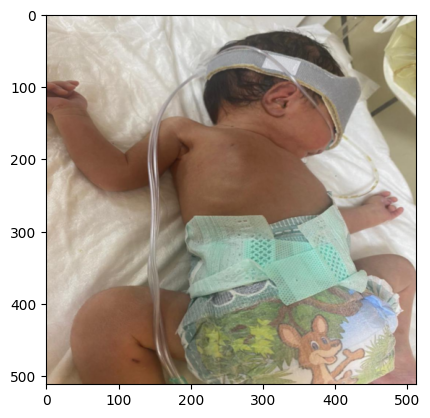

In [19]:
import matplotlib.pyplot as plt

def inference(test_data):
  idx = torch.randint(1, len(test_data), (1,))
  sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)
  print(test_data[idx][1])

  if torch.sigmoid(model(sample)) < 0.5:
    print("Prediction : normal")
  else:
    print("Prediction : jaundice")


  plt.imshow(test_data[idx][0].permute(1, 2, 0))

inference(test_data)

In [26]:
import matplotlib.pyplot as plt

model.eval()
with torch.inference_mode():
    count = 0
    output = []
    for idx in range(len(test_data)):
        sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)

        if (torch.sigmoid(model(sample)) < 0.5 and test_data[idx][1] == 0) or (torch.sigmoid(model(sample)) >= 0.5 and test_data[idx][1] == 1):
            count += 1
            output.append(test_data[idx][1])
        else:
            output.append(int(torch.round(torch.sigmoid(model(sample)))))


accuracy = (count/len(test_data)) * 100

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(range(len(test_data)),output, color = 'r')
ax2.scatter(range(len(test_data)),test_data[:,1],color = 'g')
accuracy

error: OpenCV(4.8.1) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x0114d669::Set<3,-1,-1>,struct cv::impl::A0x0114d669::Set<0,5,-1>,3>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


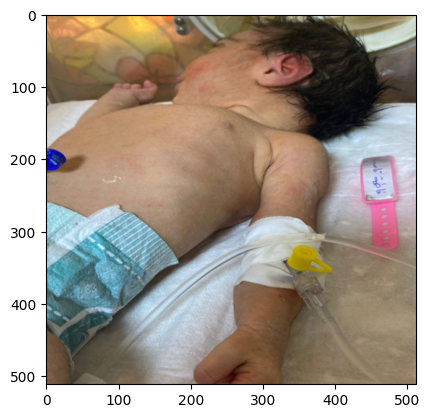

In [51]:
import matplotlib.pyplot as plt

model.eval()
with torch.inference_mode():
    # for i, (images, labels) in enumerate(testloader):
    # idx = torch.randint(1, len(test_data), (1,))
    images,labels = next(iter(trainloader))

    plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
    # plt.imshow(np.transpose(train_np[0],(1,2,0)))

    # testimage, testlabel = next(iter(trainloader))
    # print(testimage.shape)
    # plt.imshow(np.transpose(np.array(testimage[1:]),(1,2,0)))
    # print(testlabel)

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics



confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

resnet34 512x512 img - 77.63157894736842<br>
resnet18 512x512 img - 76.97368421052632 52min 10.9sec<br>
resnet50 512x512 img - 73.68421052631578 153min 49.4 sec<br>
resnet152 my laptop can't handle<br>
densnet 26.1342567 <br>
alexnet 512x512 img - 73.68421052631578 - 14min 48.3sec<br>
googlenet - 73.68421052631578 - 67min 33.1 sec